This notebook is for snapping of substations to lines

In [1]:
#Requires to have geopandas installed
#Installation https://geopandas.org/getting_started/install.html

import matplotlib.pyplot as plt 
import geopandas as gpd
import geoplot
import pandas as pd
import fiona #;help(fiona.open)
import requests
from pandas import json_normalize
import requests # convert json into dataframe
#For OSM 
import pyrosm
import numpy as np
from pyrosm import OSM, get_data

# Africa shape data

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world

In [3]:
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')

mena = saudi.append(yemen).append(iraq).append(oman).append(uae).append(jordan).append(palestine).append(israel).append(qatar).append(kuwait)

In [4]:
africa = world.query('continent == "Africa"').append(mena)
#africa.head()

In [5]:
#africa.plot()

In [6]:
nigeriaplot = world.query('name == "Nigeria"')

# Power data

In [7]:
import os
import sys

In [8]:
pathg = os.path.realpath("data")+'/africa_all_generators.geojson'
paths = os.path.realpath("data")+'/africa_all_substations.geojson'
pathl = os.path.realpath("data")+'/africa_all_lines.geojson'

generators = gpd.read_file(pathg)
points = gpd.read_file(paths)
lines = gpd.read_file(pathl)

In [9]:
points

,id,tags.power,tags.substation,Type,tags.voltage,tags.location,Country,geometry
0,2000011529,substation,None,Node,None,None,nigeria,POINT (5.58060 6.35724)
1,2161137620,substation,None,Node,None,None,nigeria,POINT (5.61271 6.29842)
2,2161121796,substation,None,Node,None,None,nigeria,POINT (5.60564 6.29269)
3,5604720218,substation,None,Node,None,None,nigeria,POINT (13.14095 11.81140)
4,3605463946,substation,distribution,Node,None,None,nigeria,POINT (7.05415 4.79218)
...,...,...,...,...,...,...,...,...
177,553840946,substation,None,Way,None,None,nigeria,POINT (7.40793 6.43085)
178,745794408,substation,None,Way,None,None,nigeria,POINT (3.50612 6.62516)
179,108020974,substation,transmission,Way,330000,outdoor,nigeria,POINT (3.24824 6.60294)
180,564766375,substation,None,Way,None,None,nigeria,POINT (6.32832 4.99027)


In [10]:
offset = 0.001
bbox = points.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(lines.sindex.intersection(row)), axis=1)

In [11]:
bbox

,minx,miny,maxx,maxy
0,5.579595,6.356240,5.581595,6.358240
1,5.611710,6.297419,5.613710,6.299419
2,5.604645,6.291686,5.606645,6.293686
3,13.139950,11.810400,13.141950,11.812400
4,7.053148,4.791176,7.055148,4.793176
...,...,...,...,...
177,7.406928,6.429846,7.408928,6.431846
178,3.505122,6.624165,3.507122,6.626165
179,3.247239,6.601937,3.249239,6.603937
180,6.327321,4.989268,6.329321,4.991268


In [12]:
lines

,tags.cables,id,voltage_V,Country,tags.frequency,Type,tags.power,geometry
0,3,556530547,330000,nigeria,50,Way,line,"LINESTRING (12.03564 9.47188, 12.06749 9.45378..."
1,3,671706473,330000,nigeria,50,Way,line,"LINESTRING (6.67247 6.18240, 6.54451 6.20798, ..."
2,3,108020973,330000,nigeria,None,Way,line,"LINESTRING (3.24623 6.60354, 3.20852 6.64188, ..."
3,3,671606207,330000,nigeria,50,Way,line,"LINESTRING (5.64271 5.92388, 5.64376 5.92449)"
4,None,575700599,330000,nigeria,None,Way,line,"LINESTRING (6.83858 6.12865, 6.84329 6.13240)"
...,...,...,...,...,...,...,...,...
448,3,563719558,132000,nigeria,50,Way,line,"LINESTRING (6.38485 7.51681, 6.43479 7.52091, ..."
449,None,565151711,132000,nigeria,None,Way,line,"LINESTRING (7.84441 12.55145, 7.71787 12.69933..."
450,6,669957218,330000,nigeria,None,Way,line,"LINESTRING (3.61539 6.56653, 3.59858 6.57680, ..."
451,6,564385545,330000,nigeria,50,Way,line,"LINESTRING (7.23103 9.15335, 7.22281 9.15776, ..."


In [13]:
display(hits)

0             [15, 85]
1             [15, 85]
2             [15, 85]
3                   []
4                   []
            ...       
177                 []
178         [302, 349]
179    [167, 226, 190]
180                 []
181       [32, 7, 117]
Length: 182, dtype: object

In [14]:
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})

In [15]:
tmp

,pt_idx,line_i
0,0,15.0
1,0,85.0
2,1,15.0
3,1,85.0
4,2,15.0
...,...,...
449,179,226.0
450,179,190.0
451,181,32.0
452,181,7.0


In [16]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(lines.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(points.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=points.crs)

In [17]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

ipykernel_launcher:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [18]:
tolerance = 0.1 # 10km
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])



In [19]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

In [20]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))
# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

In [21]:
#Identify the columns we want to copy from the closest line to the point, such as a line ID.
line_columns = 'line_i'
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(
closest[line_columns],geometry=new_pts)

# Join back to the original points:
updated_points = points.drop(columns=["geometry"]).join(snapped)
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

In [22]:
updated_points.to_file('./updates_points.geojson', driver="GeoJSON")  # Generate GeoJson

# Map

<AxesSubplot:>

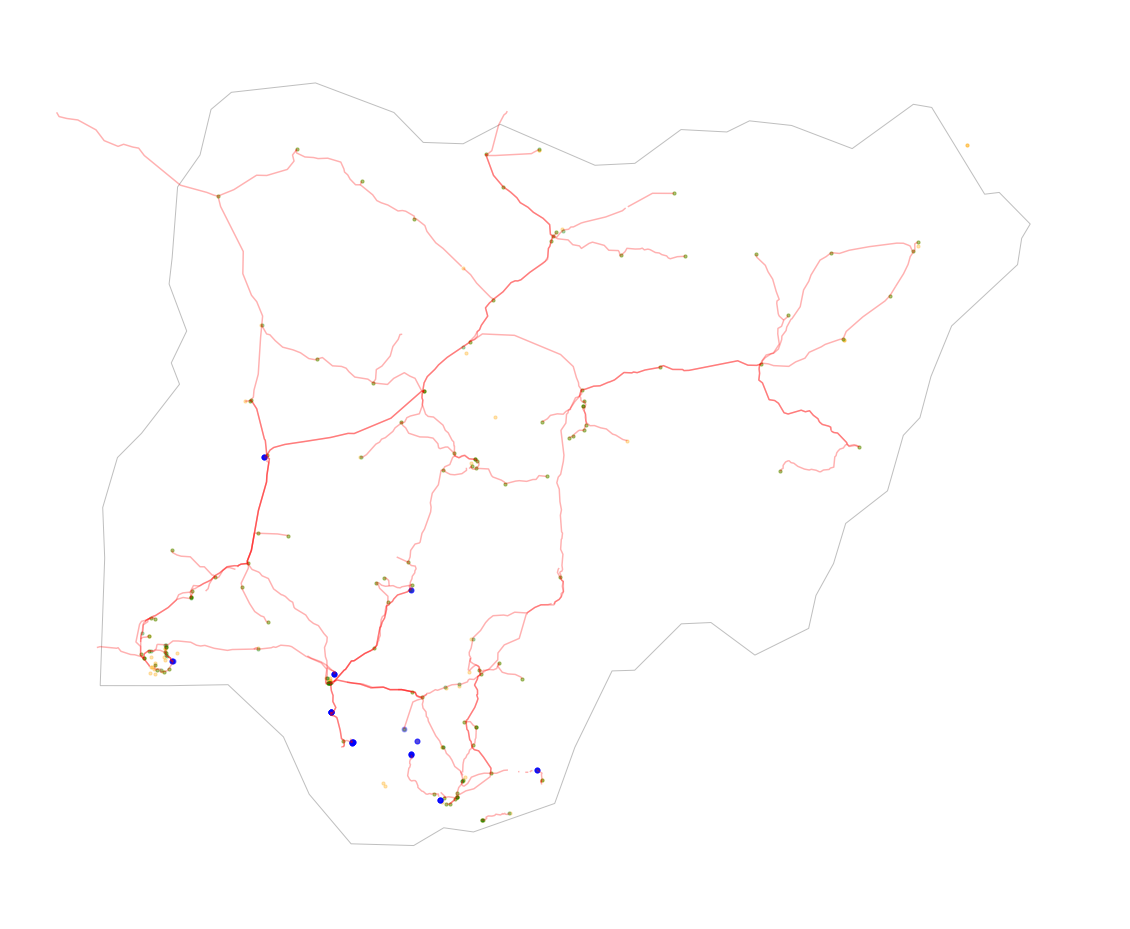

In [23]:
ax = geoplot.polyplot(nigeriaplot ,edgecolor='grey', alpha = 0.5, figsize=(20, 20))

points.loc[points['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=10, color='orange',alpha = 0.3, ax=ax)
updated_points.loc[updated_points['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=10, color='green',alpha = 0.3, ax=ax)
generators.loc[generators['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='blue',alpha = 0.3, ax=ax)
lines.loc[lines['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='red',alpha = 0.3, ax=ax)


#plt.savefig('africa_transmission_and substations_110.png')

In [26]:
import pandas as pd
import hvplot.pandas

df = pd.read_csv(
    "https://raw.githubusercontent.com/FRESNA/powerplantmatching/master/matched_data_red.csv",
    index_col=0
)

df.hvplot.points(
    'lon',
    'lat',
    geo=True,
    frame_height=750,
    c='Fueltype',
    size=df["Capacity"] / 5,
    alpha=0.4,
    tiles='CartoLight',
    hover_cols=['Name', 'Fueltype', "Technology", 'YearCommissioned', "Retrofit", "Capacity"],
    xlim=(-12,32),
).opts(
    active_tools=['pan', 'wheel_zoom']
)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (Fueltype,_size,Name,Technology,YearCommissioned,Retrofit,Capacity)

In [29]:
substation_df = pd.read_csv(
    "./data/africa_all_substations.csv",
    index_col=0
)

substation_df.hvplot.points(
    'lon',
    'lat',
    geo=True,
    frame_height=750,
    c='Fueltype',
    size=df["Capacity"] / 5,
    alpha=0.4,
    tiles='CartoLight',
    hover_cols=['Name', 'Fueltype', "Technology", 'YearCommissioned', "Retrofit", "Capacity"],
    xlim=(-12,32),
).opts(
    active_tools=['pan', 'wheel_zoom']
)

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['lon', 'lat']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html